## Introduction

Using this [dataset of 160K tracks taken from Spotify](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks), we want to answer the following questions:

Looking at the audio features, which ones influence popularity?
Does this influence change over time? Ie: do we see different correlations between features and popularity for tracks released in the 60s, compared to tracks released in in 2020?
Does this change based on the musical genre of the track?
How accurately can we predict a track's popularity score using its metadata and its audio features?

For this EDA, we will be following the standard CRISP-DM framework, starting with...

## Business Understanding

This dataset of 160K tracks was pulled from the Spotify API by Yamac Eren Ay. 

Each track has the standard metadata you'd expect (title, artist(s), etc), but also a number of calculated metrics called "Audio Features". These allow a more in-depth understanding of each track, by giving information about how the track feels, its mood, its composition, tempo, and much more.

There's a good summary of these audio features in [this article](https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404#:~:text=The%20Spotify%20Web%20API%20developer,beat%20strength%2C%20and%20overall%20regularity.&text=Tempo%3A%20The%20overall%20estimated%20tempo,beats%20per%20minute%20(BPM)):

- Danceability: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
- Valence: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- Energy: Represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.
- Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece, and derives directly from the average beat duration.
- Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
- Speechiness: This detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
- Instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”.
- Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
- Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- Key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
- Mode: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- Duration: The duration of the track in milliseconds.
- Time Signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

Each entry in the dataset also has the track's all important "popularity". This is a metric derived from the number of times the track has been listened to, with more weight for more recent listens. 

## Data Understanding

We'll start by loading the libraries we need, and then start to explore the data. 

We'll look at whether the dataset carries any null values, and whether there is information in the other available datasets (genres and artists) that we want to join into this dataset to enrich it.

In [2]:
%load_ext pycodestyle_magic

In [3]:
%pycodestyle_on

In [4]:
%config Completer.use_jedi = False

We need to import the following libraries for this EDA:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sc
from sklearn.model_selection import train_test_split
import numpy as np
import ast
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from collections import Counter

In [6]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)
pd.options.display.max_rows

20

We'll start by reading the main file for this dataset:

In [3]:
df = pd.read_csv('data.csv')
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [6]:
df[['name','year','artists','valence','acousticness','danceability','duration_ms','energy','explicit','popularity']].sample(n=5)

,name,year,artists,valence,acousticness,danceability,duration_ms,energy,explicit,popularity
6683,I'll Never Be The Same - Remastered,1955,['Frank Sinatra'],0.152,0.9750,0.217,185867,0.1500,0,30
66781,A Couple More Years - Remastered,1978,['Willie Nelson'],0.326,0.3020,0.455,241000,0.2430,0,32
157797,The Foggy Dew,1956,"['The Clancy Brothers', 'Tommy Makem']",0.468,0.9670,0.652,213893,0.0826,0,5
15496,Supe Perder,1999,['Los Caminantes'],0.929,0.0259,0.707,177853,0.6350,0,63
86025,Come to Me,1989,['Hiroshima'],0.644,0.4970,0.587,323840,0.3460,0,40


Let's check the dataset for null values:

In [8]:
total_null_counts = np.sum(df.isnull())
total_null_counts

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

We see that there are no null values in this dataset - good stuff.

Let's look at which genres are most represented within this dataset, by joining the track data file ('data.csv') with the artist and genre file ('data_w_genres.csv') using the artist as the join key:

In [9]:
df_genres = pd.read_csv('data_w_genres.csv')
merged_df = pd.merge(df, df_genres, on='artists')
merged_df.shape

(0, 34)

We see that simply joining on the 'artists' column doesn't work, and yields a dataframe with 0 rows. This is likely due to a mismatched type between the 'artists' column in df and the 'artists' column in df_genres:

In [10]:
df['artists'][0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [11]:
df_genres['artists'][0]

'"Cats" 1981 Original London Cast'

Although they're both of object (actually string) type, we see that they are structured differently, with a list type contained within the string in df.
However, we assume that if we break the artist list in df out into its component artists, we should be able to find corresponding rows in df_genres - as we can see in the following example:

In [12]:
df_genres[df_genres['artists'] == 'James Levine']

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
11305,"['classical performance', 'opera', 'orchestral...",James Levine,0.944056,0.264578,328057.111111,0.166089,0.446163,0.232672,-19.4915,0.048306,102.657,0.165772,25.833333,10,1,18


What is the range for the possible count of artists a track can have? We need this to decide how we will model our data to be able to make the join:

In [13]:
artist_count = []
for i in df['artists'].index:
    # The line below adds the count of artists for each track
    artist_count.append(len(ast.literal_eval(df['artists'][i])))

In [14]:
# This gives us the number of tracks for each distinct artist count:
tracks_by_artist_count = Counter(artist_count)

<BarContainer object of 23 artists>

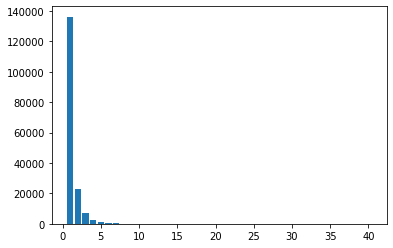

In [15]:
fig, ax = plt.subplots()
ax.bar(list(tracks_by_artist_count.keys()),
       list(tracks_by_artist_count.values()))

In [17]:
stats.describe(artist_count)

DescribeResult(nobs=170653, minmax=(1, 40), mean=1.3272371420367646, variance=0.7778272099951887, skewness=6.324286654122509, kurtosis=91.29684312705011)

In [18]:
p = np.percentile(artist_count, 99)
p

5.0

From the above, we see that:
- Songs in this dataset have a maximum of 40 artists
- The dataset has a mean of 1.32 with a low variance of 0.77
- There are just a few outliers with more than 5 artists - 99% of tracks have less than 5 artists

Based on this, we will add 5 columns for potential artists. For the 1% of outliers with more than 5 artists, we will simply select the first 5 artists in the 'artists' column.

## Preparing the data

Now that we have an idea of how this dataset is constructed, let's make some changes to be able to start building our models. There are no null values in the base dataset, which means we don't need to worry about deleting nulls or imputing missing values.

However, we do want to add some information about the track genre(s) based on the song artist, which will require us to join the dataset with the "artists" dataset.

Once we'd done that, we'll run a few more queries to increase our data understanding with the new information added in, and then move on to modelling, so that we start making predictions and answering the business questions stated above.

Note: the function below takes a long time to run, might be possible to refactor for a later version of this EDA.

In [19]:
# This block of code is really slow! it will take about 10 mins to run:
artists_expanded = pd.DataFrame(columns=[
    'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5'])
for i in range(df.shape[0]):
    track_artists = df['artists'].iloc[i]
    track_artists_expanded = ast.literal_eval(track_artists)
    data = []
    values = []
    for i in range(5):
        try:
            values.append(track_artists_expanded[i])
        except:
            values.append("")
        zipped = zip(artists_expanded.columns, values)
        artists_dict = dict(zipped)
    artists_expanded = artists_expanded.append(artists_dict, True)

12:9: E722 do not use bare 'except'


In [20]:
artists_expanded.head(n=10)

,artist_1,artist_2,artist_3,artist_4,artist_5
0,Sergei Rachmaninoff,James Levine,Berliner Philharmoniker,,
1,Dennis Day,,,,
2,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,,,,
3,Frank Parker,,,,
4,Phil Regan,,,,
5,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,,,,
6,John McCormack,,,,
7,Sergei Rachmaninoff,,,,
8,Ignacio Corsini,,,,
9,Fortugé,,,,


In [21]:
df_expanded = pd.concat([df, artists_expanded], axis=1)
df_expanded.shape

(170653, 24)

We've expanded the 'artists' column into sub_columns as planned, now let's merge the dataframe with the 'df_genres' data to get the genres for each track:

In [22]:
df_genres.columns

Index(['genres', 'artists', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity', 'key', 'mode', 'count'],
      dtype='object')

In [23]:
df_expanded.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4',
       'artist_5'],
      dtype='object')

In [24]:
df_expanded.shape

(170653, 24)

In [25]:
%pycodestyle_off # This is needed as pycodestyle causes the code block below to break

In [26]:
# for i in range(5):
#     left_key = 'artist_'+ str(i+1)
#     right_key = 'artists'
#     new_genre_column = 'genre' + str(i+1)
#     new_artist_column = 'artist_' + str(i+1) + '_y'
#     df_expanded = pd.merge(df_expanded, df_genres, left_on=left_key,right_on=right_key).rename(columns={'genres':new_genre_column,'artists_y':new_artist_column})
# df_expanded.drop(['artist_1_y','artists_x','artists_3_y','artists_5_y'],axis=1)
# I couldn't get the above loop to work properly and didn't want to spend more time on this, 
# so I'm just going to iterate 5 times and remove the columns I don't want. 
df_expanded = pd.concat([df,artists_expanded],axis=1) # just to reset the dataframe
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_1',right_on='artists').rename(columns={'genres':'genre_1','artists_y':'artist_1_y'}).drop(columns=['artists_x'])
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_2',right_on='artists').rename(columns={'genres':'genre_2','artists':'artist_2_y'})
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_3',right_on='artists').rename(columns={'genres':'genre_3','artists':'artist_3_y'})
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_4',right_on='artists').rename(columns={'genres':'genre_4','artists':'artist_4_y'})
df_expanded.columns
df_expanded = pd.merge(df_expanded, df_genres[['genres','artists']], how='left', left_on='artist_5',right_on='artists').rename(columns={'genres':'genre_5','artists':'artist_5_y'})
df_expanded.columns

Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5',
       'genre_1', 'artist_1_y', 'genre_2', 'artist_2_y', 'genre_3',
       'artist_3_y', 'genre_4', 'artist_4_y', 'genre_5', 'artist_5_y'],
      dtype='object')

In [27]:
%pycodestyle_on # Turning it back on for the rest of the notebook

Let's run a quick sanity check below, to make sure that the y columns match with the original and that everything in our sample makes sense. The artist columns named 'artist_n_y' are just there for this sanity check, otherwise they're redundant:

In [28]:
df_expanded.iloc[:, 18:35].head(n=10)

,artist_1,artist_2,artist_3,artist_4,artist_5,genre_1,artist_1_y,genre_2,artist_2_y,genre_3,artist_3_y,genre_4,artist_4_y,genre_5,artist_5_y
0,Sergei Rachmaninoff,James Levine,Berliner Philharmoniker,,,"['classical', 'post-romantic era', 'russian ro...",Sergei Rachmaninoff,"['classical performance', 'opera', 'orchestral...",James Levine,"['classical', 'classical performance', 'german...",Berliner Philharmoniker,NaN,NaN,NaN,NaN
1,Dennis Day,,,,,[],Dennis Day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,,,,,[],KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Frank Parker,,,,,[],Frank Parker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Phil Regan,,,,,[],Phil Regan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,,,,,[],KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,John McCormack,,,,,"['irish ballad', 'vintage classical singing']",John McCormack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Sergei Rachmaninoff,,,,,"['classical', 'post-romantic era', 'russian ro...",Sergei Rachmaninoff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Ignacio Corsini,,,,,"['tango', 'vintage tango']",Ignacio Corsini,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Fortugé,,,,,['vintage chanson'],Fortugé,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's quickly rename our new even more expanded dataframe for easier reference:

In [29]:
df_tracks_with_genres = df_expanded
df_tracks_with_genres.columns

Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5',
       'genre_1', 'artist_1_y', 'genre_2', 'artist_2_y', 'genre_3',
       'artist_3_y', 'genre_4', 'artist_4_y', 'genre_5', 'artist_5_y'],
      dtype='object')

Currently, the genres in each 'genre_n' column are stored in lists, making it hard to get a picture of how each one is represented within the track data. Let's find out how each genre is represented in the 'genre_1' column, by breaking these lists up (shoutout to https://github.com/softhints/python/blob/master/notebooks/pandas/Pandas_count_values_in_a_column_of_type_list.ipynb)

In [30]:
df_tracks_with_genres.genre_1.value_counts().sort_values(ascending=False)

[]                                                                                                                                                     17586
['tango', 'vintage tango']                                                                                                                              2861
['adult standards', 'easy listening', 'lounge']                                                                                                         1173
['classical', 'classical era']                                                                                                                          1099
['classical', 'early romantic era', 'polish classical']                                                                                                 1017
                                                                                                                                                       ...  
['chicago house', 'deep house', 'disco house', 'diva house

First I need to remove the 'NaN' values from the genre_1 column, which were causing my column to have multiple data types and breaking the code further down. I can simply replace them with '[]':

In [31]:
df_tracks_with_genres['genre_1'] = df_tracks_with_genres.genre_1.fillna('[]')

In [32]:
# Below, we check whether we have managed to remove
# all the float type values

df_tracks_with_genres[df_tracks_with_genres['genre_1']
                      .apply(lambda x: isinstance(x, float))]

,valence,year,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,...,genre_1,artist_1_y,genre_2,artist_2_y,genre_3,artist_3_y,genre_4,artist_4_y,genre_5,artist_5_y


In [33]:
df_all_genres = df_tracks_with_genres.genre_1.map(
    lambda x: x.lstrip('[').rstrip(']')).str.split(',', expand=True)
df_all_genres.shape

(170653, 23)

Note: from the shape of the df_all_genres dataframe, we can tell that a given artist can have up to 23 different genres within this dataset!

In [34]:
df_comb = pd.DataFrame()
genre_index = []
df_all_genres.fillna(0, inplace=True)

In [35]:
df_all_genres.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,'classical','post-romantic era','russian romanticism','ukrainian classical',0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
# Again, the block below is taken from softhint's solution on Github
# but essentially, it iterates through the columns of the df_all_genres df
# counting the values for each genre in each column,
# and adding it to the df_comb dataframe
# and also reindexing it:

for col in df_all_genres.columns:
    if col == 0:
        df_comb['total'] = df_all_genres[col].fillna(0).value_counts()
        genre_index = df_all_genres[col].value_counts().index
    else:
        col_ser = df_all_genres[col].fillna(0).value_counts()
        col_ser = col_ser.reindex(genre_index, fill_value=0)
        df_comb['total'] = df_comb['total'] + col_ser
df_comb.iloc[1:].sort_values('total', ascending=False).head(10)

,total
'adult standards',14763
'album rock',12181
'classical',8686
'dance pop',4652
'alternative metal',4286
'bebop',3901
'alternative rock',3517
'tango',2881
'contemporary country',2585
'classic bollywood',2261


Finally, we plot the count of the top 10 genres to get an idea of the distribution of genres in the track dataset, for the genre_1 column:

Text(0, 0.5, 'count of distinct tracks')

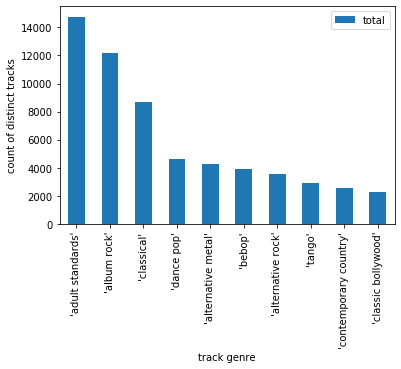

In [37]:
df_comb_top_10 = df_comb.iloc[1:].nlargest(10, 'total')
ax = df_comb_top_10.plot.bar()
ax.set_xlabel('track genre')
ax.set_ylabel('count of distinct tracks')

We notice that the top genres in this column are 'album rock', 'classical', and 'dance pop'. Later, we'll come back to tracks of specific genres to see how our correlations change.

Let's first of all look at the coefficients between the different numerical columns, with a particular focus on the track popularity as that's what we will be looking to predict:

In [38]:
df_tracks_with_genres.corr()['popularity'].sort_values(ascending=False)

popularity          1.000000
year                0.862442
energy              0.485005
loudness            0.457051
danceability        0.199606
explicit            0.191543
tempo               0.133310
duration_ms         0.059597
valence             0.014200
key                 0.007826
mode               -0.028897
liveness           -0.076464
speechiness        -0.171979
instrumentalness   -0.296750
acousticness       -0.573162
Name: popularity, dtype: float64

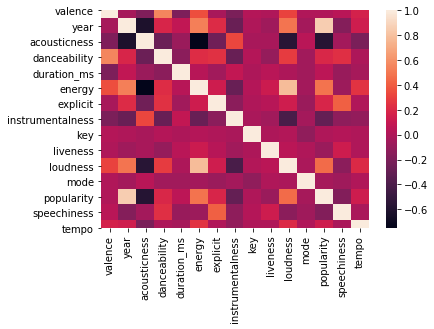

In [39]:
sns.heatmap(df_tracks_with_genres.corr())

We appear to have a strong correlation between the year the track was released and its popularity. We also have a strong correlation between the track "energy" and its popularity.
Conversely, we have a strong negative correlation between a track's acousticness and its popularity, as well as between a track's instrumentalness and it's popularity.

In [40]:
df_popularity_with_genres = df_tracks_with_genres[['genre_1', 'popularity']]
df_popularity_with_genres.groupby('genre_1').mean().sort_values(
    by='popularity', ascending=False).head(n=20)

,popularity
genre_1,
"['latin pop', 'viral pop']",92.000000
"['cubaton', 'latin', 'pop venezolano', 'reggaeton', 'trap latino']",89.000000
['tropical house'],88.000000
['south african house'],86.000000
"['dance pop', 'house', 'pop', 'pop dance', 'tropical house', 'uk dance']",85.500000
"['afroswing', 'london rap', 'rap']",85.000000
"['basshall', 'francoton']",85.000000
"['edm', 'german dance', 'pop dance', 'pop edm', 'tropical house']",84.500000
"['australian pop', 'pop', 'uk pop']",84.000000


Above, we see this confirmed by taking a quick look at the top 20 genres in terms of track popularity within this dataset. They do in fact tend to be mostly "dancy" genres like "reggaeton" and "latin pop", which are less likely to be 'acoustic' or 'instrumental'

In [41]:
df_popularity_with_genres = df_tracks_with_genres[['genre_1', 'popularity']]
df_popularity_with_genres.groupby('genre_1').mean().sort_values(
    by='popularity', ascending=True).head(n=20)

,popularity
genre_1,
"['big band', 'dixieland', 'new orleans jazz', 'stride', 'swing', 'vintage jazz']",0.0
"['russian modern classical', 'russian romanticism']",0.0
['russian shoegaze'],0.0
['rwandan traditional'],0.0
['ryukyu ongaku'],0.0
"['danish classical', 'neoclassicism']",0.0
['danish classical'],0.0
['danish jazz'],0.0
['jazz trombone'],0.0


Whereas the cell above shows the bottom 20 tracks in terms of popularity, with more classical genres like "romanticism" and "medieval folk" - which would indeed tend to be more instrumental, for example. However due to the granularity of the genre column, conclusions here are a bit limited.

## Data modelling

Now that we have our new expanded dataset, and a good understanding of how it is structured, as well as some insights into how the different data points - in particular the audio features and the popularity - are correlated, let's move on to building a simple model.

In [42]:
# Remind me what the available columns are
df_tracks_with_genres.columns

Index(['valence', 'year', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'explicit', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'artist_1', 'artist_2', 'artist_3', 'artist_4', 'artist_5',
       'genre_1', 'artist_1_y', 'genre_2', 'artist_2_y', 'genre_3',
       'artist_3_y', 'genre_4', 'artist_4_y', 'genre_5', 'artist_5_y'],
      dtype='object')

Below I'm creating the input data, removing things like the track name and ID. I'm also removing the year for now, which I will come back to. Then I'll break this into test and training datasets:

In [43]:
X = df_tracks_with_genres[['valence', 'acousticness', 'danceability',
                           'duration_ms', 'energy', 'explicit',
                           'instrumentalness', 'key',
                           'liveness', 'loudness',
                           'mode', 'speechiness', 'tempo']]
y = df_tracks_with_genres[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
reg_without_year = LinearRegression()
reg_without_year.fit(X_train, y_train)
y_pred = reg_without_year.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.4524871865229938

We get an r_squared of 0.45, meaning that 45% of the popularity metric's variability can be explained by the list of audio features we've selected for our linear model. This is "not bad" for an extremely human metric like track popularity.

We also want to build a model which takes the track release year into account. We expect a very high coefficient, as the correlation between year and popularity was actually among the strongest, with a coefficient of 0.86. We'll add the year by creating dummy columns for all available years:

In [44]:
df_dummy_years = pd.get_dummies(
    df_tracks_with_genres['year'],
    drop_first=True, prefix='year',
    prefix_sep='_')

In [45]:
df_dummy_years.shape

(170653, 99)

In [46]:
df_with_dummies = pd.concat([df_tracks_with_genres, df_dummy_years], axis=1)
df_with_dummies.head(n=5)

,valence,year,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,0.0594,1921,0.982,0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,...,0,0,0,0,0,0,0,0,0,0
1,0.9630,1921,0.732,0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,...,0,0,0,0,0,0,0,0,0,0
2,0.0394,1921,0.961,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,...,0,0,0,0,0,0,0,0,0,0
3,0.1650,1921,0.967,0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,...,0,0,0,0,0,0,0,0,0,0
4,0.2530,1921,0.957,0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df_with_dummies.shape

(170653, 132)

In [48]:
df_with_dummies.head()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,...,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
0,0.0594,1921,0.982,0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,...,0,0,0,0,0,0,0,0,0,0
1,0.9630,1921,0.732,0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,...,0,0,0,0,0,0,0,0,0,0
2,0.0394,1921,0.961,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,...,0,0,0,0,0,0,0,0,0,0
3,0.1650,1921,0.967,0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,...,0,0,0,0,0,0,0,0,0,0
4,0.2530,1921,0.957,0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,...,0,0,0,0,0,0,0,0,0,0


We have a lot of redundant columns left over from our merge to get the track genre. Let's run through the DataFrame and delete those:

In [49]:
for i in range(5):
    column_name = 'artist_' + str(i + 1)
    column_name_2 = 'artist_' + str(i + 1) + '_y'
    column_name_3 = 'genre_' + str(i + 1)
    df_with_dummies = df_with_dummies.drop(
        [column_name, column_name_2, column_name_3], axis=1)

In [50]:
X_with_year = df_with_dummies.drop(
    ['name', 'year', 'id', 'name', 'release_date', 'popularity'], axis=1)
y_with_year = df_with_dummies[['popularity']]
X_train_year, X_test_year, y_train_year, y_test_year = train_test_split(
    X_with_year, y_with_year, test_size=0.33, random_state=42)
reg_with_year = LinearRegression()
reg_with_year.fit(X_train_year, y_train_year)
y_pred_year = reg_with_year.predict(X_test_year)
sc.metrics.r2_score(y_test_year, y_pred_year)

0.7898819162651358

We see here that we have a much higher r squared when we add the year the track was released into the model

## Evaluating the results

With our two models complete and working as expected, we can start interpreting our results, starting by looking at the coefficients used in each model to get an idea of how impactful each "audio feature" is on the track popularity:

In [51]:
# The below function is taken from the
# Udacity Introduction to Data Science course

def coef_weights(reg, coefficients, X_train):
    '''
    INPUT:
    reg - a linear regression model
    coefficients - the coefficients of the linear model
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)

    Provides a dataframe that can be used
    to understand the most influential coefficients
    in a linear model by providing the coefficient estimates
    along with the name of the
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = reg.coef_[0]
    coefs_df['abs_coefs'] = np.abs(reg.coef_[0])
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df


coeff_check = coef_weights(reg_without_year, reg_without_year.coef_, X_train)
coeff_check

,est_int,coefs,abs_coefs
11,speechiness,-3.421594e+01,3.421594e+01
2,danceability,2.188359e+01,2.188359e+01
1,acousticness,-2.145597e+01,2.145597e+01
0,valence,-1.948614e+01,1.948614e+01
4,energy,1.086990e+01,1.086990e+01
5,explicit,9.224895e+00,9.224895e+00
6,instrumentalness,-8.673283e+00,8.673283e+00
8,liveness,-7.880551e+00,7.880551e+00
9,loudness,2.396114e-01,2.396114e-01
10,mode,-1.000482e-01,1.000482e-01


Again, our linear regression model using all available Spotify audio features *except the track year* as inputs confirms the following: we have a strong negative correlation with "speechiness", "acousticness" and "valence", and a strong positive correlation with "danceability", "acousticness" and "energy". 
Additionally, whether or not a track is marked as "explicit" also appears to be correlated to its popularity.
Our linear model has an r_squared of 0.45 - ie 45% of the variability of the "popularity" variable can be explained and predicted through a combination of the Spotify metrics.

Let's look at the coefficients for our linear model which included the track release year, to see how things change when we add that high influence data point into the mix:

In [52]:
coeff_check = coef_weights(reg_with_year, reg_with_year.coef_, X_train_year)
coeff_check

,est_int,coefs,abs_coefs
110,year_2019,6.286182e+01,6.286182e+01
111,year_2020,6.088081e+01,6.088081e+01
108,year_2017,6.066970e+01,6.066970e+01
109,year_2018,6.035531e+01,6.035531e+01
107,year_2016,5.690386e+01,5.690386e+01
106,year_2015,5.392875e+01,5.392875e+01
105,year_2014,5.267172e+01,5.267172e+01
104,year_2013,5.156279e+01,5.156279e+01
102,year_2011,5.083568e+01,5.083568e+01
101,year_2010,5.039044e+01,5.039044e+01


We see that the more recently a track was released, the higher its popularity - this is not surprising considering how the popularity score is calculated: "The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are."

Another question we might ask is, how do the different correlations evolve based on the track release year?
Let's look at the most heavily correlated inputs: acousticness,danceability,energy,explicit,loudness

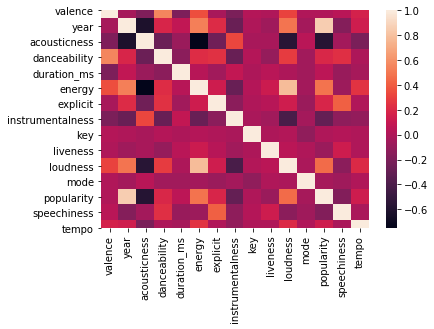

In [53]:
sns.heatmap(df_tracks_with_genres.corr())

In [106]:
# explicitness:
df_explicit = pd.DataFrame()
for year in range(1921, 2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity', 'explicit']].corr()
    df_explicit[year] = df_correlation['popularity']

df_explicit = df_explicit.transpose()

In [107]:
# acousticness:
df_acoustic = pd.DataFrame()
for year in range(1921, 2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity', 'acousticness']].corr()
    df_acoustic[year] = df_correlation['popularity']

df_acoustic = df_acoustic.transpose()

In [108]:
# danceability:
df_danceable = pd.DataFrame()
for year in range(1921, 2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity', 'danceability']].corr()
    df_danceable[year] = df_correlation['popularity']

df_danceable = df_danceable.transpose()

In [109]:
# energy:
df_energy = pd.DataFrame()
for year in range(1921, 2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity', 'energy']].corr()
    df_energy[year] = df_correlation['popularity']

df_energy = df_energy.transpose()

In [110]:
# loudness:
df_loudness = pd.DataFrame()
for year in range(1921, 2021):
    df_truncated = df_tracks_with_genres[df_tracks_with_genres['year'] == year]
    df_correlation = df_truncated[['popularity', 'loudness']].corr()
    df_loudness[year] = df_correlation['popularity']

df_loudness = df_loudness.transpose()

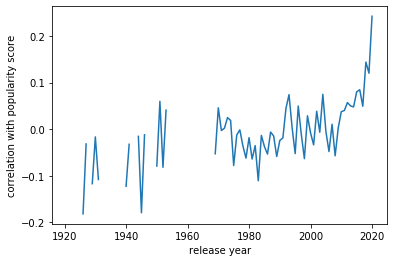

In [59]:
fig, ax = plt.subplots()
ax.set_xlabel('release year')
ax.set_ylabel('correlation with popularity score')
ax.plot(df_explicit['explicit'])

We have a lot of null values in the past for the "explicit" audio feature, which is unsurprising as I can't think of many 1940s equivalent of the Wu Tang clan. We also see that the correlation increases over time, reaching > 0.2 for tracks released in 2020.

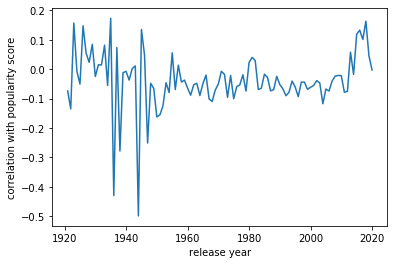

In [60]:
fig, ax = plt.subplots()
ax.set_xlabel('release year')
ax.set_ylabel('correlation with popularity score')
ax.plot(df_acoustic['acousticness'])

Here we actually see a spike in the acousticness correlation coefficient between 2010 and 2020

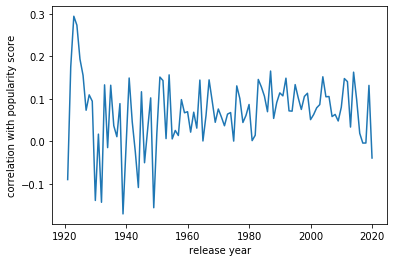

In [61]:
fig, ax = plt.subplots()
ax.set_xlabel('release year')
ax.set_ylabel('correlation with popularity score')
ax.plot(df_loudness['loudness'])

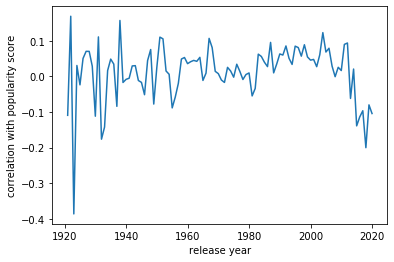

In [62]:
fig, ax = plt.subplots()
ax.set_xlabel('release year')
ax.set_ylabel('correlation with popularity score')
ax.plot(df_energy['energy'])

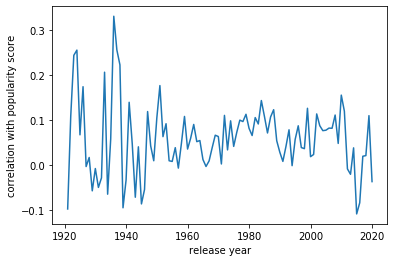

In [63]:
fig, ax = plt.subplots()
ax.set_xlabel('release year')
ax.set_ylabel('correlation with popularity score')
ax.plot(df_danceable['danceability'])

Now, let's create another linear regression model, but limiting the dataset to just tracks that are in the classical genre for their first artist (I'm ignoring other artists here for the sake of simplicity). We'll also ingore the release year, as this will let us focus on the impact of the audio features of the track. First, we need to create that dataset:

In [64]:
df_classical_tracks = df_tracks_with_genres[df_tracks_with_genres['genre_1'].str.contains('classical')]

1:80: E501 line too long (103 > 79 characters)


In [65]:
df_classical_tracks.shape[0]/df_tracks_with_genres.shape[0]

0.07497084727487943

Based on the above cell, we see that tracks with "classical" in their first genre account for about 7% of the total.

In [66]:
X = df_classical_tracks[
    ['valence', 'acousticness', 'danceability', 'duration_ms', 'energy',
     'explicit', 'instrumentalness', 'key',
     'liveness', 'loudness', 'mode', 'speechiness', 'tempo']]
y = df_classical_tracks[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.1650507509316229

We have a much lower r-squared than what we measured when considering the dataset as a whole, likely due to the smaller amount of data we're considering. Let's look at the correlation coefficients:

In [69]:
coeff_check = coef_weights(reg, reg.coef_, X_train)
coeff_check

,est_int,coefs,abs_coefs
1,acousticness,-3.146571e+01,3.146571e+01
5,explicit,3.114641e+01,3.114641e+01
4,energy,1.291151e+01,1.291151e+01
8,liveness,-1.136989e+01,1.136989e+01
11,speechiness,-8.671941e+00,8.671941e+00
2,danceability,-3.120098e+00,3.120098e+00
6,instrumentalness,1.738344e+00,1.738344e+00
10,mode,-1.090748e+00,1.090748e+00
9,loudness,-7.367451e-01,7.367451e-01
7,key,-1.122659e-01,1.122659e-01


Here we see that danceability is now negatively correlated. However we also see that explicitness is positively correlated, which points out the limitations of this analysis, as there are actually only 3 tracks in this dataset that are considered explicit:

In [70]:
df_classical_tracks[df_classical_tracks['explicit'] > 0]

,valence,year,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,...,genre_1,artist_1_y,genre_2,artist_2_y,genre_3,artist_3_y,genre_4,artist_4_y,genre_5,artist_5_y
16522,0.575,2004,0.214000,0.828,225107,0.653,1,1p5kC161fWMA2QlwV3Vi4W,0.000003,0,...,"['background music', 'background piano', 'calm...",Eamon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72330,0.494,2006,0.869000,0.504,263160,0.434,1,7eL4Z9FlNY5u9vOsgpDUsw,0.003400,7,...,"['bluegrass', 'classical mandolin', 'instrumen...",Chris Thile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121450,0.149,2003,0.000011,0.514,467827,0.950,1,6hz6lrQtLcxOOjflnYjF9o,0.013500,7,...,"['metal', 'neo classical metal', 'power metal'...",Dream Theater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's have a go with just tracks that have 'adult standards' in the genre_1 column. First, we need to create that dataset:

In [74]:
df_adult_standards = df_tracks_with_genres[
    df_tracks_with_genres['genre_1'].str.contains('adult standards')]

In [72]:
df_adult_standards.shape

(14800, 33)

In [77]:
X = df_adult_standards[['valence', 'acousticness',
                        'danceability', 'duration_ms',
                        'energy', 'explicit',
                        'instrumentalness', 'key',
                        'liveness', 'loudness', 'mode',
                        'speechiness', 'tempo']]
y = df_adult_standards[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.15151218885591

Again, a very low r-squared, so any conclusions here to be taken with a pinch of salt.

In [79]:
coeff_check = coef_weights(reg, reg.coef_, X_train)
coeff_check

,est_int,coefs,abs_coefs
11,speechiness,-21.410754,21.410754
1,acousticness,-14.128893,14.128893
4,energy,13.452653,13.452653
5,explicit,13.299901,13.299901
6,instrumentalness,-9.835791,9.835791
8,liveness,-9.290904,9.290904
0,valence,-8.017715,8.017715
2,danceability,6.217002,6.217002
10,mode,1.285695,1.285695
9,loudness,-0.247669,0.247669


We can call out speechiness and acousticness as tending to drive popularity down for adult standards tracks, while enery drives them up.

Let's have a go with just tracks that have 'pop' in the genre_1 column. First, we need to create that dataset:

In [81]:
df_pop_tracks = df_tracks_with_genres[
    df_tracks_with_genres['genre_1'].str.contains('pop')]

In [82]:
df_pop_tracks.shape[0]/df_tracks_with_genres.shape[0]

0.2639391044986024

In [85]:
X = df_pop_tracks[['valence', 'acousticness', 'danceability',
                   'duration_ms', 'energy', 'explicit',
                   'instrumentalness', 'key', 'liveness',
                   'loudness', 'mode', 'speechiness',
                   'tempo']]
y = df_pop_tracks[['popularity']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.36867946012556996

Slightly higher r-squared than for the previous two examples, as the we're looking at about 26% of all tracks.

In [87]:
coeff_check = coef_weights(reg, reg.coef_, X_train)
coeff_check

,est_int,coefs,abs_coefs
2,danceability,27.823029,27.823029
0,valence,-23.963726,23.963726
11,speechiness,-15.170827,15.170827
1,acousticness,-14.596796,14.596796
6,instrumentalness,-9.473604,9.473604
8,liveness,-7.292525,7.292525
5,explicit,5.536701,5.536701
4,energy,1.969830,1.969830
9,loudness,1.034690,1.034690
10,mode,-0.448868,0.448868


Here we see that danceability is now positively correlated. It actually seems like the main thing to look for in a pop track.

Finally, playing around with some actual tracks to get a feel for how the model works, and to help me explain the logic in my Medium post. 

First we need to reset our model, to be based on our dataset as a whole and not just a specific genre:

In [88]:
X = df_with_dummies.drop(
    ['name', 'year', 'id', 'name', 'release_date', 'popularity'], axis=1)
y = df_with_dummies['popularity']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
sc.metrics.r2_score(y_test, y_pred)

0.7898819162651358

And now, let's look at a few tracks (I selected these with a random sample of 3 tracks taken from the whole dataset):

In [94]:
df_tracks_with_genres[df_tracks_with_genres['id'] == '27ycaQnQAxaPiyeg3nr2aB'][[
    'valence', 'acousticness', 'danceability',
    'duration_ms', 'energy', 'explicit',
    'instrumentalness', 'key', 'liveness',
    'loudness', 'mode', 'speechiness', 'tempo', 'popularity']]

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity
19643,0.259,0.00115,0.705,223279,0.814,0,0.00312,4,0.203,-5.466,0,0.0346,110.0,91


1:80: E501 line too long (80 > 79 characters)


Listening to this Miley Cyrus pop track we hear it has low speechiness (very few 'spoken words'), seems pretty high on danceability, and is definitely not acoustic, so we'd expect it to have a pretty high popularity score. The model predicts 64 - but it's a Miley Cyrus track, so it actually gets 91!

In [95]:
X_midnight_sky = df_with_dummies[
    df_with_dummies['id'] == '27ycaQnQAxaPiyeg3nr2aB'].drop(
    ['name', 'year', 'id', 'name', 'release_date', 'popularity'], axis=1)
midnight_sky_prediction = reg.predict(X_midnight_sky)
midnight_sky_prediction

array([64.22618144])

In [99]:
df_tracks_with_genres[df_tracks_with_genres['id'] == '0vK1vDEvEMvSpFEKW62Qub'][[
    'valence', 'acousticness', 'danceability',
    'duration_ms', 'energy', 'explicit',
    'instrumentalness', 'key', 'liveness',
    'loudness', 'mode', 'speechiness', 'tempo',
    'popularity', 'year']]

,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity,year
140843,0.42,0.209,0.649,203322,0.64,0,0.000532,6,0.0965,-6.09,1,0.0352,94.957,66,2020


1:80: E501 line too long (80 > 79 characters)


Listening to this really boring song by Jordan Davis, we hear low speechiness again, definitely not explicit, not very danceable, and quite a lot of acoustic sounds. However we see that Spotify measures danceability quite high, at 0.64. In general we'd expect a middling to low popularity score here, except for the very important fact that the track was released this year. Our model spits out a score of 64, which is extremely close to the reality of 66.

In [100]:
X_lose_you = df_with_dummies[
    df_with_dummies['id'] == '0vK1vDEvEMvSpFEKW62Qub'].drop(
    ['name', 'year', 'id', 'name', 'release_date', 'popularity'], axis=1)
lose_you_prediction = reg.predict(X_lose_you)
lose_you_prediction

array([64.22889043])

In [103]:
df_tracks_with_genres[df_tracks_with_genres['id'] == '1pOs0EmRYSB2qHkq3RqQ3F'][[
    'name', 'valence', 'acousticness', 'danceability',
    'duration_ms', 'energy', 'explicit',
    'instrumentalness', 'key', 'liveness',
    'loudness', 'mode', 'speechiness',
    'tempo', 'popularity', 'year']]

,name,valence,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,popularity,year
3824,Somebody Else Is Taking My Place,0.727,0.929,0.737,188560,0.363,0,0.168,8,0.0977,-10.962,1,0.0711,131.274,14,1941


1:80: E501 line too long (80 > 79 characters)


Listening to this track, I find it quite danceable, very likely entirely acoustic, with almost no speechiness. However, as it came out in 1940, we would expect that fact alone to drive popularity down significantly into the low 25s. In fact, our model gives it a score of 3.3, whereas in reality it has a score of 14.

In [104]:
X_peggy_lee = df_with_dummies[
    df_with_dummies['id'] == '1pOs0EmRYSB2qHkq3RqQ3F'].drop(
    ['name', 'year', 'id', 'name', 'release_date', 'popularity'], axis=1)
peggy_lee_prediction = reg.predict(X_peggy_lee)
peggy_lee_prediction

array([3.29623334])

Thanks for reading!

## References and credit:
    - Found this article later - he doesn't use a linear regression but gets a very similar result with his graphs! https://towardsdatascience.com/what-makes-a-song-likeable-dbfdb7abe404#:~:text=The%20Spotify%20Web%20API%20developer,beat%20strength%2C%20and%20overall%20regularity.&text=Tempo%3A%20The%20overall%20estimated%20tempo,beats%20per%20minute%20(BPM).
    - Used this solution for some grouping problem: https://github.com/softhints/python/blob/master/notebooks/pandas/Pandas_count_values_in_a_column_of_type_list.ipynb
    - I'm currently following the Udacity Data Science Nanodegree, so a lot of this analysis was inspired from the lessons in that course.